<h1 class="text-center">BCI - Introduction to EEG classification for a MI BCI</h1>
<h2 class="text-center">February, 2022</h2>

<br>

The purpose of this tutorial is to implement a Motor Imagery BCI, using a public dataset (Cho, H., Ahn, M., Ahn, S., Kwon, M. and Jun, S.C., 2017. EEG datasets for motor imagery brain computer interface. GigaScience.). You will use MNE to load and pre-process the data and Sklearn+MNE for the classification part. 
</b></div>

- In Section I, exploration data analysis and epoching using MNE
- In Section II, a first classifier is trained based on Common Spatial Patterns and Linear Discriminant Analysis.
- In Section III, some possible improvements of this baseline pipeline
- MOABB toolbox is used in Section IV to implement more elaborated pipeline
- The last section (V) is an opportunity to improve and explore other pipelines from what you learnt today.

The code must be completed after each **Question** to work, where "HERE" appears as a comment in the code. The parameters that do not change the course of the story are accompanied "EDIT ME!" as a comment: you can change them at the time or at the end of the section to see the changes involved.

### Then we define a hack that will hide the very verbose output of some functions.

In [2]:
import os, sys
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

# I - Motor Imagery Dataset: 
BCI experiment for motor imagery movement (MI movement) of the left and right hands. EEG data were collected using 64 Ag/AgCl active electrodes. A 64-channel montage based on the international 10-20 system was used to record the EEG signals with 512 Hz sampling rates. The EEG device used in this experiment was the Biosemi ActiveTwo system. The BCI2000 system 3.0.2 was used to collect EEG data and present instructions (left hand or right hand MI). 

**Subjects were asked to imagine the hand movement depending on the instruction given.** Five or six runs were performed during the MI experiment. After each run, we calculated the classification accuracy over one run and gave the subject feedback to increase motivation. Between each run, a maximum 4-minute break was given depending on the subject’s demands. (cf [MOABB dataset](http://moabb.neurotechx.com/docs/generated/moabb.datasets.Cho2017.html) or
[gigadb datasets](http://gigadb.org/dataset/100295))

### We load the dataset, and plot the sensor locations:

Trials demeaned and stacked with zero buffer to create continuous data -- edge effects present
Trials demeaned and stacked with zero buffer to create continuous data -- edge effects present


<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG, 4 EMG, 1 Stimulus
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: unspecified
 nchan: 69
 projs: []
 sfreq: 512.0 Hz
>


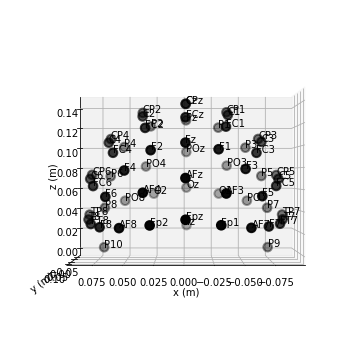

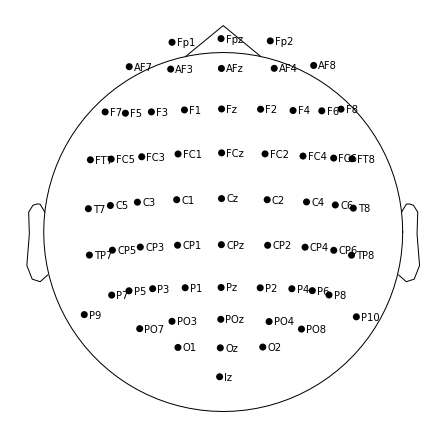

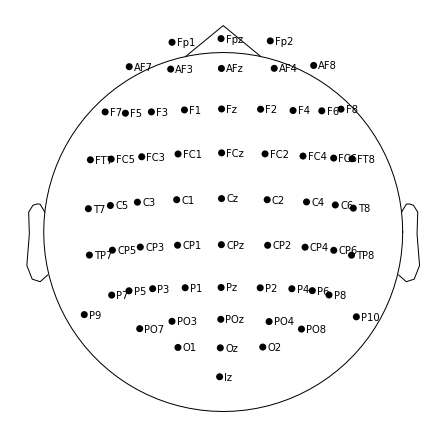

In [3]:
import matplotlib.pyplot as plt
from moabb.datasets import Cho2017

# define and load the dataset
ds = Cho2017()
raws = ds.get_data(subjects=[1,2])
raw = raws[1]['session_0']['run_0']

# show infos
print(raw.info)

# display the montage (sensors on the scalp)
plt.rcParams['figure.dpi'] = 150
raw.plot_sensors(ch_type='eeg',show_names=True, kind='3d')
#plt.show()
raw.plot_sensors(ch_type='eeg',show_names=True)
#plt.show()

### Here we plot the EEG data, that is:
$$ \mathbb{S} = \begin{pmatrix} s_{11} & s_{12} & \ldots & s_{1T}\\
                        s_{21} & s_{22} & \ldots & s_{2T}\\
                        \cdots & & & \cdots\\
                        s_{C1} & s_{C2} & \ldots & s_{CT} \end{pmatrix} $$
with $T$ the number of time points in the considered interval $[t_{min},t_{max}]$, $C$ the number of channels.

In [ ]:
# plot the EEG signals
plt.rcParams['figure.dpi'] = 150
scal = dict(eeg=1e-3)                      # EDIT ME!
raw.plot(n_channels=64, scalings=scal,
         start=15, duration=2,             # EDIT ME!
         lowpass=200, highpass=5,          # EDIT ME!
         show_scrollbars=False, show_scalebars=False)
plt.show()

### Let's show some of the studied events

In [ ]:
from mne import find_events

# Get the event (left / right hand) by looking at the "stim" channel.
events = find_events(raw, shortest_event=0, verbose=True)

# Display tge EEG signals with the events 
scal = dict(eeg=5e-3)     # EDIT ME!
plt.rcParams['figure.dpi'] = 150
raw.plot(events=events, event_color='red', event_id=ds.event_id,
         scalings=scal, clipping=None, show_scrollbars=False, show_scalebars=False, 
         start=680,       # EDIT ME!
         duration=40,     # EDIT ME!
         n_channels=64)   # EDIT ME!
plt.show()

### Some other tools

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (1.650 sec)

Effective window size : 4.000 (s)


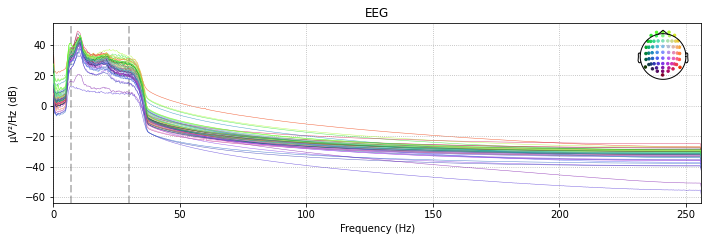

Effective window size : 4.000 (s)


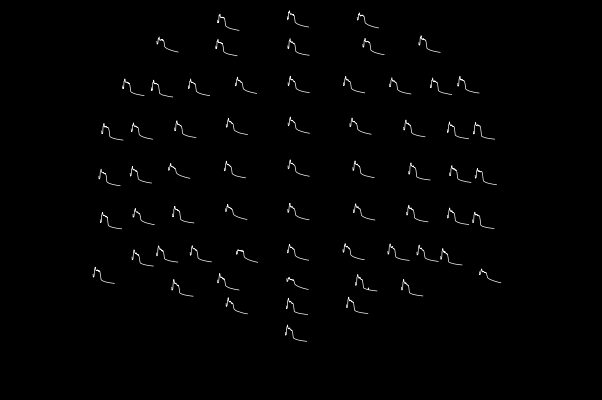

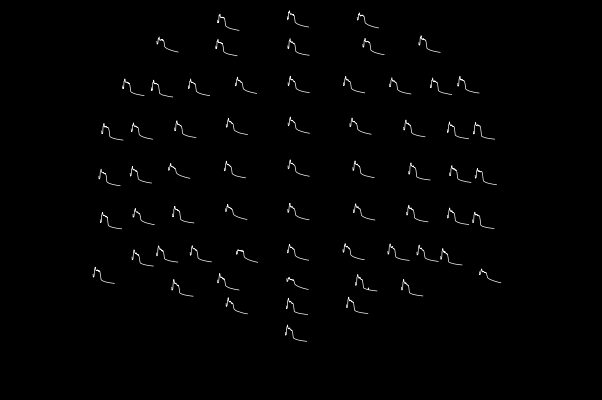

In [4]:
raw_left = raw.copy()

# crop data between tmin and tmax
tmin,tmax=0,600                                                          # EDIT ME!
raw_left.crop(tmin,tmax)                                                     

# filter data
raw_left.filter(7., 30., fir_design='firwin', skip_by_annotation='edge') # EDIT ME!

# power spectral density
raw_left.plot_psd()
#plt.show()

# topomap with power spectral densities
plt.rcParams['figure.dpi'] = 100
raw_left.plot_psd_topo()
#plt.show()

### Let's epoch the data:
Each epoch $\mathbb{S}_i$, with $i \in \{1, \ldots, n\}$, corresponds to a time window located at a given event.
An epoch will produce a sample to be classified, *i.e.* a row of the matrix
$$ \mathbb{X} = \begin{pmatrix}
f_1(\mathbb{S}_1) & f_2(\mathbb{S}_1) & \ldots & f_d(\mathbb{S}_1)\\
f_1(\mathbb{S}_2) & f_2(\mathbb{S}_2) & \ldots & f_d(\mathbb{S}_2)\\
\cdots & & & \cdots\\
f_1(\mathbb{S}_n) & f_2(\mathbb{S}_n) & \ldots & f_d(\mathbb{S}_n)\\
\end{pmatrix}.$$

In [61]:
from mne import Epochs, find_events

def load_epoch(raws, subject_nb, event_id, fmin = 7., fmax = 35.):
    """Function to load epoched data for a specified subject"""
    
    raw = raws[subject_nb]['session_0']['run_0']

    # Apply band-pass filter
    raw.filter(fmin, fmax, fir_design='firwin', skip_by_annotation='edge')

    # Get the event (left / right hand) by looking at the "stim" channel.
    events = find_events(raw, shortest_event=0, verbose=True)

    picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                       exclude='bads')
    tmin, tmax = -1., 4.
    # Read epochs (train will be done only between 1 and 2s)
    # Testing will be done with a running classifier
    epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                    baseline=None, preload=True)
    labels = epochs.events[:, -1] - 1
    return epochs, labels

In [62]:
ds = Cho2017()
event_id = ds.event_id
raws = ds.get_data(subjects=[1,2])

epochs, labels = load_epoch(raws, 1, event_id)
epoch_train = epochs.copy().crop(tmin=1., tmax=2.)
epochs_data_train = epoch_train.get_data()

Trials demeaned and stacked with zero buffer to create continuous data -- edge effects present
Trials demeaned and stacked with zero buffer to create continuous data -- edge effects present


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 845 samples (1.650 sec)

200 events found
Event IDs: [1 2]
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 200 events and 2561 original time points ...
0 bad epochs dropped


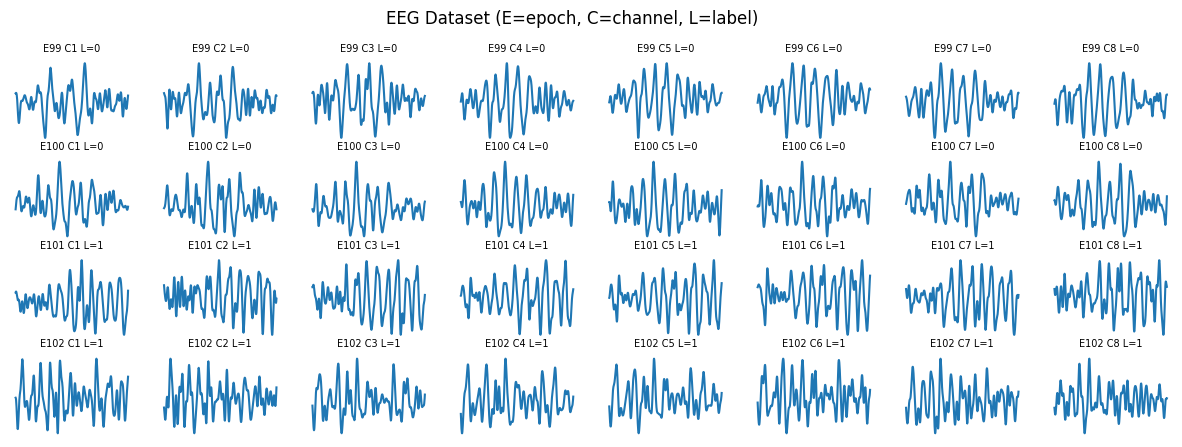

In [63]:
# Show epochs
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100
max_sample = 4
max_channel= 8
first_epoch = 98
for s in range(max_sample):
    for c in range(max_channel):
        index = s*max_channel + c + 1
        plt.subplot(max_sample, max_channel, index)
        plt.axis('off')
        plt.plot(epoch_train.get_data()[s+first_epoch,c,:])
        title = f'E{s+first_epoch+1} C{c+1} L={labels[s+first_epoch]}'
        plt.title(title, fontsize=7)
plt.suptitle('EEG Dataset (E=epoch, C=channel, L=label)');
plt.show()

# II - A first classification pipeline: CSP + LDA
**Question**: use the mne function [CSP](https://mne.tools/0.23/generated/mne.decoding.CSP.html), and the sklearn functions [LinearDiscriminantAnalysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) and [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) to define a classifier *clf* as 
$$ \mbox{EEG data} \rightarrow CSP \rightarrow LDA \rightarrow \mbox{prediction}$$ 

In [64]:
import numpy as np
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from mne.decoding import CSP

# Assemble a classifier
lda = LinearDiscriminantAnalysis()                               # HERE
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline
clf = Pipeline([('CSP', csp), ('LDA', lda)])                     # HERE

**Question**: use the sklearn functions [ShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit) and [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) to evaluate this classifier.

In [65]:
# Define a cross-validation generator
scores = []
epochs_data = epochs.get_data()
cv = ShuffleSplit(10, test_size=0.2, random_state=42)            # HERE

# Evaluate the resulting classifier using cross-validation
with HiddenPrints():
    scores = cross_val_score(clf, epochs_data_train, labels, 
                             cv=cv, n_jobs=-1, verbose=False)         # HERE

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("\n\nClassification accuracy: %f / Chance level: %f \n\n" % (np.mean(scores),
                                                          class_balance))

Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
    Using tolerance 0.0042 (2.2e-16 eps * 64 dim * 3e+11  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0044 (2.2e-16 eps * 64 dim * 3.1e+11  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
    Using tolerance 0.0045 (2.2e-16 eps * 64 dim * 3.1e+11  max singular value)
Reducing data rank from 64 -> 64
Estimating covariance 

### We display now the CSP patterns

{'component_order': 'mutual_info', 'cov_est': 'concat', 'cov_method_params': None, 'log': True, 'n_components': 4, 'norm_trace': False, 'rank': None, 'reg': None, 'transform_into': 'average_power'}


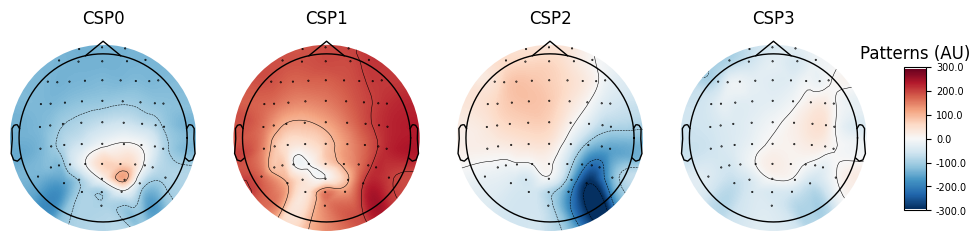

In [66]:
# plot CSP patterns estimated on full data for visualization
with HiddenPrints():
    csp.fit_transform(epochs_data, labels)
    
print(csp.get_params())

#plt.rcParams['axes.grid'] = False
#csp.plot_filters(epochs.info, ch_type='eeg', units='Filters (AU)', size=1.5)
#plt.show()

plt.rcParams['axes.grid'] = False
csp.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)
plt.show()

### Test the classifier on a sliding window

Here, we would wike to evaluate the predictive power of different time windows of the epochs.

**Question**: 
- First, compute cv_split using the its *split* attribute of the [ShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit) cross-validation ```cv```.
- Then, in the loop on the couples (Training set,Validation set) of cv_split: 
    - compute X_train using the method *fit_transform* of the [Common Spatial Pattern](https://mne.tools/0.23/generated/mne.decoding.CSP.html) ```csp``` defined earlier, on the the epochs of the training set ```epochs_data_train[train_idx]``` and the labels ```y_train```.
    - train the [LinearDiscriminantAnalysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) classifier ```lda``` defined earlier using its method *fit* on the features ```X_train``` and the labels ```y_train```.
    - then, in the loop on the sliding windows, compute X_test using the method *transform* of the [Common Spatial Pattern](https://mne.tools/0.23/generated/mne.decoding.CSP.html) ```csp``` just trained, on the epochs of the testing set ```epochs_data[test_idx][:, :, n:(n + w_length)]```.

Sampling frequency: 512.0


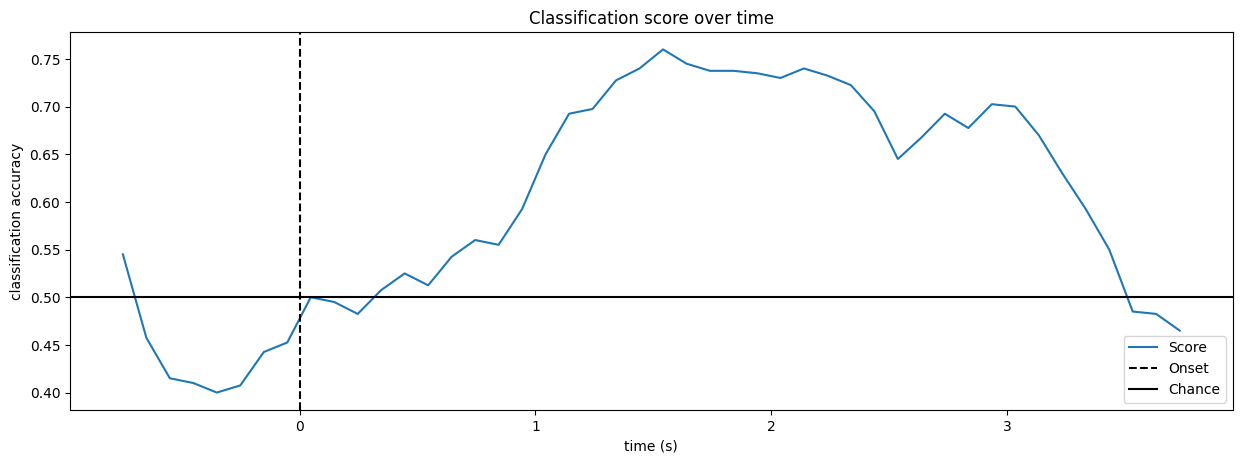

In [67]:
sfreq = raw.info['sfreq']
print(f'Sampling frequency: {sfreq}')

# window length = number of samples during 0.5secs
w_length = int(sfreq * 0.5)   # running classifier: window length 
# window step size = number of samples during 0.1secs
w_step = int(sfreq * 0.1)  # running classifier:
# different starting indices considering a w_length-length window and a w_step-length step
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windows = []
cv_split = cv.split(epochs_data_train)                                        # HERE

# for each couple Training set / Validation set
for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    # fit CSP
    with HiddenPrints():
        X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)    # HERE
    # fit LDA
    lda.fit(X_train, y_train)                                                 # HERE

    # running classifier: test classifier on sliding window
    score_this_window = []
    # for each time window
    for n in w_start:
        # compute the CSP components on the time window
        X_test = csp.transform(epochs_data[test_idx][:, :, n:(n + w_length)]) # HERE
        score_this_window.append(lda.score(X_test, y_test))
    scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.) / sfreq + epochs.tmin
plt.plot(w_times, np.mean(scores_windows, 0), label='Score')
plt.axvline(0, linestyle='--', color='k', label='Onset')
plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('classification accuracy')
plt.title('Classification score over time')
plt.legend(loc='lower right')
plt.show()

### A first cross-subject test
**Question**: Load the data of the second participant, and evaluate the accuracy of the classifier $CSP+LDA$ trained on the first participant.

In [68]:
epochs_s02, labels_s02 = load_epoch(raws, 2, event_id)
epoch_train_s02 = epochs_s02.copy().crop(tmin=1., tmax=2.)
epochs_data_train_s02 = epoch_train_s02.get_data()
epochs_data_s02 = epochs_s02.get_data()

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 845 samples (1.650 sec)

200 events found
Event IDs: [1 2]
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 200 events and 2561 original time points ...
0 bad epochs dropped


[0.47, 0.49, 0.5, 0.515, 0.52, 0.525, 0.51, 0.56, 0.535, 0.5, 0.545, 0.5, 0.53, 0.525, 0.545, 0.52, 0.525, 0.52, 0.535, 0.515, 0.5, 0.48, 0.49, 0.495, 0.5, 0.505, 0.475, 0.46, 0.47, 0.485, 0.47, 0.485, 0.47, 0.47, 0.46, 0.46, 0.47, 0.46, 0.465, 0.46, 0.48, 0.485, 0.49, 0.51, 0.5, 0.51]
46
46


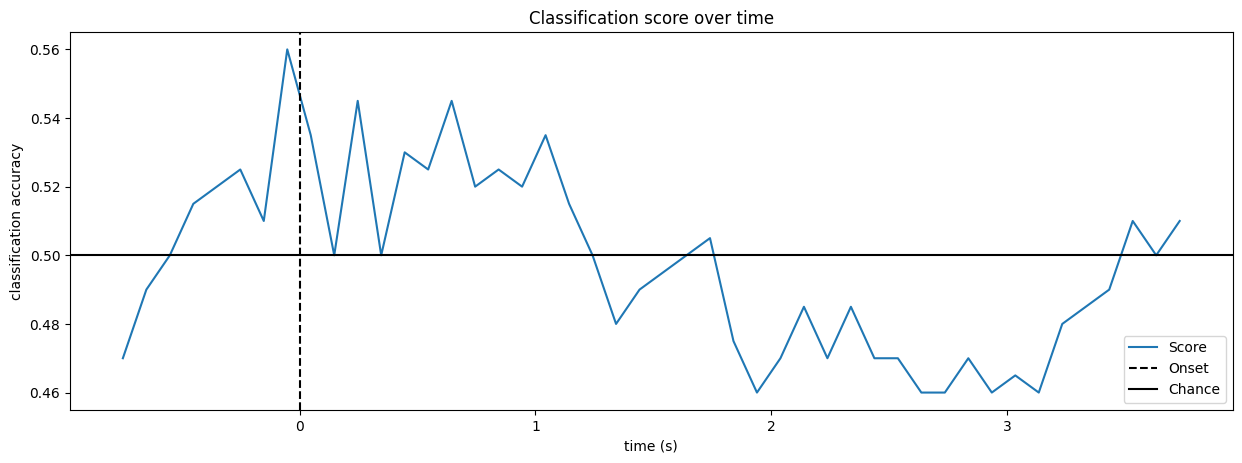

In [69]:
### START HERE ###
clf = Pipeline([('CSP', csp), ('LDA', lda)])
with HiddenPrints():
    clf.fit(epochs_data_train, labels)

score_this_window = []
# for each time window
for n in w_start:
    # compute the CSP components on the time window
    with HiddenPrints():
        score_this_window.append(clf.score(epochs_data_s02[:][:, :, n:(n + w_length)], labels_s02))
    

print(score_this_window)
# Plot scores over time
w_times = (w_start + w_length / 2.) / sfreq + epochs_s02.tmin
print(len(w_times))
print(len(score_this_window))
plt.plot(w_times, score_this_window, label='Score')
plt.axvline(0, linestyle='--', color='k', label='Onset')
plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('classification accuracy')
plt.title('Classification score over time')
plt.legend(loc='lower right')
plt.show()
### END HERE ###

# III - Improve the Brain Computer Interface

### Temporal filtering
before we have filtered data between 7-35Hz. 

**Question**: find another range (band) that leads to a higher mean accuracy ([cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)) than the pipeline at the beginning of **Section II - Preprocessing and classification** (using range 7-35Hz).   

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (1.650 sec)

200 events found
Event IDs: [1 2]
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 200 events and 2561 original time points ...
0 bad epochs dropped


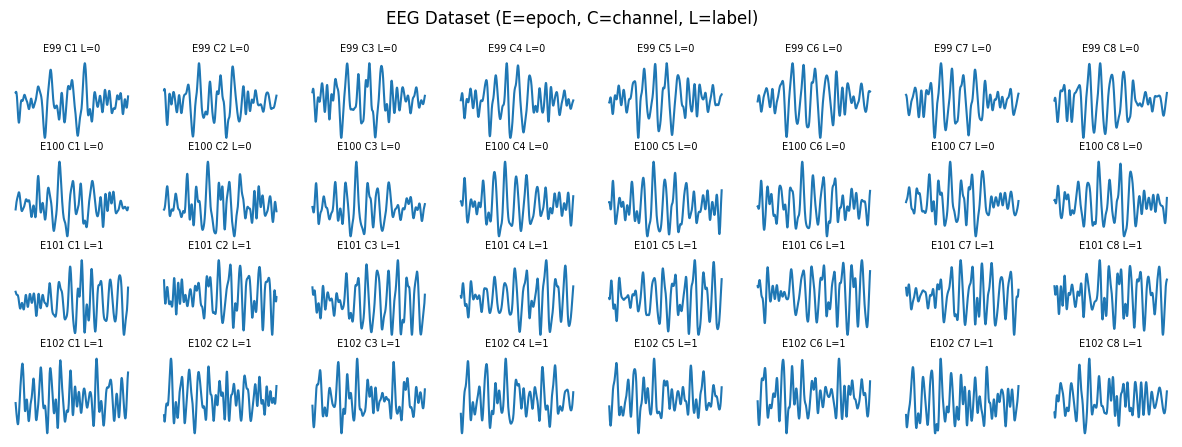

Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
    Using tolerance 0.0044 (2.2e-16 eps * 64 dim * 3.1e+11  max singular value)
    Using tolerance 0.0044 (2.2e-16 eps * 64 dim * 3.1e+11  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Estimating covariance using EMPIRICAL
Done.
Done.
Computing rank from data with rank=None
Computing rank from data with rank=None
    Using tolerance 0.0044 (2.2e-16 eps * 64 dim * 3.1e+11  max singular value)
    Estimated ra

In [71]:
epochs, labels = load_epoch(raws, 1, event_id, fmin=5., fmax = 50)
epoch_train = epochs.copy().crop(tmin=1., tmax=2.)
epochs_data_train = epoch_train.get_data()

# Show epochs
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100
max_sample = 4
max_channel= 8
first_epoch = 98
for s in range(max_sample):
    for c in range(max_channel):
        index = s*max_channel + c + 1
        plt.subplot(max_sample, max_channel, index)
        plt.axis('off')
        plt.plot(epochs_train.get_data()[s+first_epoch,c,:])
        title = f'E{s+first_epoch+1} C{c+1} L={labels[s+first_epoch]}'
        plt.title(title, fontsize=7)
plt.suptitle('EEG Dataset (E=epoch, C=channel, L=label)');
plt.show()


########## START HERE ###########
# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline
clf = Pipeline([('CSP', csp), ('LDA', lda)])
# Define a cross-validation generator
scores = []
cv = ShuffleSplit(10, test_size=0.2, random_state=42)

# Evaluate the resulting classifier using cross-validation
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=-1)
print('Mean score:', np.mean(scores))
########### END HERE ############

# IV - Evaluation with the [MOABB](http://moabb.neurotechx.com/docs/index.html) toolbox
## Advanced temporal filtering: filterbank
Filterbank idea is to divide and conquer: filter the data on different sub-bands and apply the same pipeline on each sub-band to finally gather the decisions. In our previous approach, data were filtered only in one band, the one with the best performance.  

The sub-bands design will follow roughly the well known band of humain activity:


![Brain waves](brainwaves.png)  
(source: https://www.fitmind.co/blog-collection/brainwaves-in-meditation-brain-wave-frequencies).

We will take advantage again of the pipeline (CSP + LDA) as it seems to perform the best, and apply it with a Filter Bank approach. 

This time instead of converting data to Numpy format we will let MOABB handle everything and take advantage of the evaluation functions. Therefore, we will use ```FilterBankLeftRightImagery``` paradigm from MOABB and the function ```WithinSessionEvaluation```.

In [72]:
from sklearn.pipeline import make_pipeline
from moabb.paradigms import FilterBankLeftRightImagery
from moabb.pipelines.utils import FilterBank
from moabb.evaluations import WithinSessionEvaluation

In [73]:
ds = Cho2017()
ds.subject_list = [1,2] # Use only the two first subjects

In [74]:
pipelines_fb = {}
pipelines_fb["FBCSP+LDA"] = make_pipeline(FilterBank(CSP(n_components=4)), LinearDiscriminantAnalysis())

In [75]:
filters = [[8, 12], [12, 16], [16, 20], [20, 24]]#, [24, 28], [28, 35]]
paradigm = FilterBankLeftRightImagery(filters=filters)
evaluation = WithinSessionEvaluation(
    paradigm=paradigm, datasets=ds, overwrite=True)
with HiddenPrints():
    results_fb = evaluation.process(pipelines_fb)
results_fb.head()

Cho2017-WithinSession: 100%|██████████████████████| 2/2 [01:36<00:00, 48.02s/it]


,score,time,samples,subject,session,channels,n_sessions,dataset,pipeline
0,0.8010,8.438334,200.0,1,session_0,64,1,Cho2017,FBCSP+LDA
1,0.6155,8.266763,200.0,2,session_0,64,1,Cho2017,FBCSP+LDA


Slight improvement of the performance ! Could be possible to do even better with filterbank taking advantage of higher frequencies !

**Question**: Evaluate the previous approach with higher frequencies.

### Cross-subjects
One of the advantages of MOABB is that it allows to evaluate directly the previous pipeline ```pipelines_fb``` in the cross-subject context.

**Question**: Use the MOABB evaluation ```CrossSubjectEvaluation``` to compute the scores in the cross-subject settings.

In [76]:
from moabb.evaluations import CrossSubjectEvaluation
evaluation = CrossSubjectEvaluation(                              # HERE
    paradigm=paradigm, datasets=ds, overwrite=True)              
with HiddenPrints():
    results_fb = evaluation.process(pipelines_fb)
results_fb.head()

Trials demeaned and stacked with zero buffer to create continuous data -- edge effects present
Trials demeaned and stacked with zero buffer to create continuous data -- edge effects present
Cho2017-CrossSubject: 100%|███████████████████████| 2/2 [00:19<00:00,  9.71s/it]


,score,time,samples,subject,session,channels,n_sessions,dataset,pipeline
0,0.4241,9.291002,200.0,1,session_0,64,1,Cho2017,FBCSP+LDA
1,0.5148,9.721713,200.0,2,session_0,64,1,Cho2017,FBCSP+LDA


Performance are quite low... It is not suprising as cross-subject, along cross-session, classification is one of the most challenge of the BCI !

# V - Another approach: Riemannian geometry

First, make sure you uploaded the pictures *riemann.png*, *riemann_embeding.png* and *brainwaves.png* in the folder of the notebook.

For this Riemannian method, the first step is to compute covariance matrix for each epoch. The idea is to represent an epoch with the covariance matrix, instead of the raw data. It is depicted in the following picture (from P. L. C. Rodrigues, *Exploring invariances of multivariate time series via Riemannian geometry: validation on EEG data*).



![Riemann embeding](riemann_embeding.png)  



Then these covariance matrices are projected on the Tangent Space of the manifold of the SPD (Symetric Positive-Definite) matrices (the tangent space $\approx$ the SPD manifold). 



![Riemann](riemann.png)



The projection reduces the dimension of the matrix that becomes a vector. The vectors are then classified using a [Random Forest classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

**Question**: Create and evaluate the following pipeline
$$ \mbox{EEG data} \rightarrow Covariance\ matrix \rightarrow Projection\ on\ Tangent\ Space \rightarrow Standard\ Scaler \rightarrow Random\ Forest \rightarrow\mbox{prediction}$$ 

In [77]:
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace
from sklearn.ensemble import RandomForestClassifier

epochs, labels = load_epoch(raws, 1, fmin=5., fmax = 50)
epoch_train = epochs..crop(tmin=1., tmax=2.)

# Convert from MNE object to numpy Nd-array
epochs_data_train = epochs.get_data()

# Assemble feature extractor 
cov = Covariances(estimator='scm')                                                      # HERE
ts = TangentSpace()                                                                     # HERE
ss = StandardScaler()                                                                   # HERE

# Assemble a classifier
rf = RandomForestClassifier()                                                           # HERE

# Use scikit-learn Pipeline
clf = Pipeline([('cov', cov), ('ts', ts), ('ss', ss), ('rf', rf)])                      # HERE

# Evaluate the resulting classifier using cross-validation
scores = cross_val_score(clf, epochs_data_train, labels, cv=10, n_jobs=1,verbose=False) # HERE
print('Mean score:', np.mean(scores))

SyntaxError: invalid syntax (813155294.py, line 6)

Quite powerfull, even without any tunning ! It is probably possible to improve results with better pre-processing, testing other covariance matrix estimator. Here we used 'scm' which stand for 'Sample Covariance Matrix', the maximum likelihood estimator. Some regularization could be considered: 'lwf' for Ledowit Wolf, 'oas' for Oracle Aproximating Shrinkage or 'sch' (oui ma gatée) for Schaefer-Strimmer covariance. Some tunning of the RandomForestClassifier should also be considered. 

# VI - Built a better BCI using another pipeline on this Moter Imagery Dataset
**Question** Improve one of the previous pipelines:
- select parameters using cross-validation (e.g. n_components of CSP),
- try other regularizations of the covariance matrices,
- use other data preprocessing, filters.

**Question** Try other classifiers, other features:

# IDEAS
- plot connectivity measures (hyperscan report) graphs metrics